# Deliverable 2 – Regression Modeling & Performance Evaluation  
**Course:** Advanced Data Mining (MSCS 634)  
**Student:** Sandesh Shrestha  
**Dataset:** Walmart Sales (Kaggle)  

In this deliverable, I build and evaluate regression models to predict **`Weekly_Sales`** using the Walmart Sales dataset.  

I will:
- Engineer new features (temporal, seasonal, and economic interactions).
- Develop at least two regression models (Linear Regression and Ridge Regression).
- Evaluate model performance using R-squared, MSE, and RMSE.
- Use cross-validation for more robust evaluation.
- Visualize model performance and interpret the results.


In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option("display.max_columns", None)
sns.set_theme()

## 1. Load Dataset & Basic Profiling

First, I load the Walmart Sales dataset and perform a quick profiling step to understand:
- Column data types  
- Basic statistics  
- Missing values 


Before modeling, I perform a quick data profiling step to understand structure and data types.

In [21]:
# Load dataset (assumes Walmart_Sales.csv is in the same folder as this notebook)
df = pd.read_csv("Walmart_Sales.csv")

# Peek at the first few rows
df.head()

# Structure, dtypes, and non-null counts
df.info()

# Basic numeric summary
df.describe()

# Missing values per column
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

**Observation:**

- The dataset contains weekly sales records across multiple stores.
- Key columns include `Store`, `Date`, `Weekly_Sales`, `Holiday_Flag`, `Temperature`, `Fuel_Price`, `CPI`, and `Unemployment`.
- This quick profiling helps understand the structure before cleaning and modeling.


### 2. Data Preparation (Reusing Deliverable 1 Cleaning Steps)

Here I reuse the cleaning logic from Deliverable 1:
- Strip whitespace from text columns.  
- Convert `Date` to a proper datetime type.  
- Ensure numeric columns are correctly typed.  
- Handle missing values (median for numeric, mode for categorical).  
- Remove duplicate rows.  
- Apply IQR-based outlier capping on key numeric columns.


In [22]:
# Strip whitespace from object columns
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()

# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y", errors="coerce")

# Ensure numeric types for key numeric columns
numeric_base_cols = ["Weekly_Sales", "Temperature", "Fuel_Price", "CPI", "Unemployment"]
for c in numeric_base_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")


In [23]:
# Handle missing values:
# - For numeric columns: median
# - For non-numeric: mode

for c in df.columns:
    if df[c].dtype in [np.float64, np.int64]:
        df[c] = df[c].fillna(df[c].median())
    else:
        df[c] = df[c].fillna(df[c].mode()[0])

df.isna().sum()


Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [24]:
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print("Duplicates removed:", before - after)


Duplicates removed: 0


In [25]:
def iqr_bounds(s: pd.Series):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    return q1 - 1.5 * iqr, q3 + 1.5 * iqr

bounds = {}
for c in numeric_base_cols:
    lo, hi = iqr_bounds(df[c])
    bounds[c] = (lo, hi)

# Cap outliers
for c, (lo, hi) in bounds.items():
    df[c] = np.clip(df[c], lo, hi)

for col, (low, high) in bounds.items():
    print(f"{col:15s} | Lower: {low:.2f} | Upper: {high:.2f}")


Weekly_Sales    | Lower: -746862.73 | Upper: 2720371.49
Temperature     | Lower: 6.24 | Upper: 116.16
Fuel_Price      | Lower: 1.73 | Upper: 4.94
CPI             | Lower: 10.22 | Upper: 334.26
Unemployment    | Lower: 4.29 | Upper: 11.22


**Cleaning Summary:**

- Text columns stripped of extra whitespace.  
- `Date` successfully converted to datetime.  
- Numeric fields (`Weekly_Sales`, `Temperature`, `Fuel_Price`, `CPI`, `Unemployment`) are numeric.  
- Missing values handled via median (numeric) and mode (categorical).  
- Duplicate rows removed.  
- Outliers were capped using the IQR rule to reduce the impact of extreme values.


## 3. Exploratory Look at Categorical Features

Based on Deliverable 1 feedback, I briefly explore categorical features like `Store` and `Holiday_Flag` to understand their relationship with `Weekly_Sales`.


In [27]:
# Average sales by holiday flag
holiday_sales = df.groupby("Holiday_Flag")["Weekly_Sales"].mean().reset_index()
holiday_sales


,Holiday_Flag,Weekly_Sales
0,0,1.039421e+06
1,1,1.119619e+06


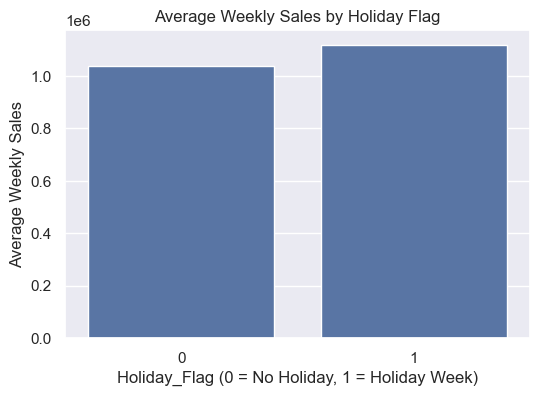

In [28]:
plt.figure(figsize=(6,4))
sns.barplot(data=holiday_sales, x="Holiday_Flag", y="Weekly_Sales")
plt.title("Average Weekly Sales by Holiday Flag")
plt.xlabel("Holiday_Flag (0 = No Holiday, 1 = Holiday Week)")
plt.ylabel("Average Weekly Sales")
plt.show()


### Insight

This chart shows that **holiday weeks have noticeably higher average weekly sales** compared to non-holiday weeks.  
The difference reflects typical retail patterns, where major holidays (Thanksgiving, Christmas, New Year, etc.) drive larger spikes in consumer purchasing activity.

This confirms that **Holiday_Flag is an important predictive feature**, as it captures consistent seasonal surges in demand. Including this variable helps the model account for structural patterns in retail behavior that are not explained by economic indicators alone.



## 4. Feature Engineering

To improve model performance and satisfy the feature engineering rubric:

I create features that capture:

1. **Temporal information**
   - `Year`, `Month`, `WeekOfYear` – capture seasonality and trends.
   - `Is_Month_Start`, `Is_Month_End` – may capture pay cycles or month-end shopping behavior.

2. **Seasonal pattern**
   - `Season` – derived from `Month` (`Winter`, `Spring`, `Summer`, `Fall`).

3. **Economic interactions**
   - `CPI_Unemployment_Ratio` = `CPI / Unemployment` – combines inflation and unemployment levels.
   - `Temp_Fuel_Interaction` = `Temperature * Fuel_Price` – potential interaction between economic and environmental conditions.

These features are designed to add meaningful signal beyond the raw columns.


In [30]:
# Temporal features from Date
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["WeekOfYear"] = df["Date"].dt.isocalendar().week.astype(int)
df["Is_Month_Start"] = df["Date"].dt.is_month_start.astype(int)
df["Is_Month_End"] = df["Date"].dt.is_month_end.astype(int)

# Season feature
def get_season(m):
    if m in [12, 1, 2]:
        return "Winter"
    elif m in [3, 4, 5]:
        return "Spring"
    elif m in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

df["Season"] = df["Month"].apply(get_season)

# Economic interaction features
df["CPI_Unemployment_Ratio"] = df["CPI"] / df["Unemployment"]
df["Temp_Fuel_Interaction"] = df["Temperature"] * df["Fuel_Price"]

df[["Date", "Year", "Month", "WeekOfYear", "Is_Month_Start", "Is_Month_End",
    "Season", "CPI_Unemployment_Ratio", "Temp_Fuel_Interaction"]].head()


,Date,Year,Month,WeekOfYear,Is_Month_Start,Is_Month_End,Season,CPI_Unemployment_Ratio,Temp_Fuel_Interaction
0,2010-02-05,2010,2,5,0,0,Winter,26.041988,108.82132
1,2010-02-12,2010,2,6,0,0,Winter,26.059977,98.12348
2,2010-02-19,2010,2,7,0,0,Winter,26.065771,100.38402
3,2010-02-26,2010,2,8,0,0,Winter,26.069534,119.41943
4,2010-03-05,2010,3,9,0,0,Spring,26.073297,122.06250


In [7]:
# Create time-based features
if "Date" in df.columns:
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["WeekOfYear"] = df["Date"].dt.isocalendar().week.astype(int)
else:
    df["Year"] = 0
    df["Month"] = 0
    df["WeekOfYear"] = 0

df[["Date", "Year", "Month", "WeekOfYear"]].head()


,Date,Year,Month,WeekOfYear
0,2010-02-05,2010,2,5
1,2010-02-12,2010,2,6
2,2010-02-19,2010,2,7
3,2010-02-26,2010,2,8
4,2010-03-05,2010,3,9


In [8]:
target = "Weekly_Sales"

numeric_features = [
    "Holiday_Flag",
    "Temperature",
    "Fuel_Price",
    "CPI",
    "Unemployment",
    "Year",
    "Month",
    "WeekOfYear"
]

categorical_features = ["Store"]

# Drop rows with missing values for the modeling columns
model_df = df.dropna(subset=[target] + numeric_features + categorical_features).copy()

X = model_df[numeric_features + categorical_features]
y = model_df[target]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (6435, 9)
Shape of y: (6435,)


In [9]:
# Train–test split: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape


((5148, 9), (1287, 9))

In [10]:
# Preprocessing pipeline: scale numeric features, one-hot encode Store
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)


In [11]:
# Model 1: Linear Regression
linreg_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

# Model 2: Ridge Regression (L2 regularization)
ridge_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=10.0, random_state=42))
])


In [12]:
# Fit both models
linreg_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [13]:
def evaluate_regression_model(name, model, X_train, y_train, X_test, y_test):
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    results = {
        "Model": name,
        "R2_Train": r2_train,
        "R2_Test": r2_test,
        "MSE_Train": mse_train,
        "MSE_Test": mse_test,
        "RMSE_Train": rmse_train,
        "RMSE_Test": rmse_test
    }
    
    return results, y_test_pred


In [14]:
linreg_results, linreg_y_pred = evaluate_regression_model(
    "Linear Regression", linreg_model, X_train, y_train, X_test, y_test
)

ridge_results, ridge_y_pred = evaluate_regression_model(
    "Ridge Regression", ridge_model, X_train, y_train, X_test, y_test
)

results_df = pd.DataFrame([linreg_results, ridge_results])
results_df


,Model,R2_Train,R2_Test,MSE_Train,MSE_Test,RMSE_Train,RMSE_Test
0,Linear Regression,0.937148,0.939430,1.948736e+10,1.891995e+10,139597.149158,137549.793483
1,Ridge Regression,0.930831,0.934984,2.144617e+10,2.030864e+10,146445.097079,142508.402255


**Model Evaluation (Hold-out Test Set):**  

The table above compares R², MSE, and RMSE for both models on the training and test sets.  
A better model will typically have:

- Higher **R²_Test**  
- Lower **RMSE_Test** / **MSE_Test**  


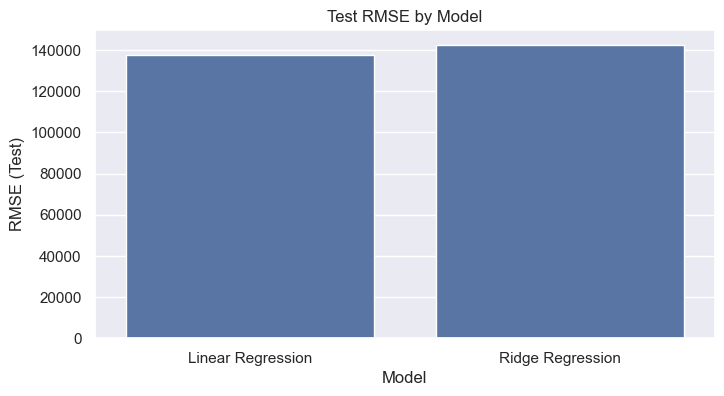

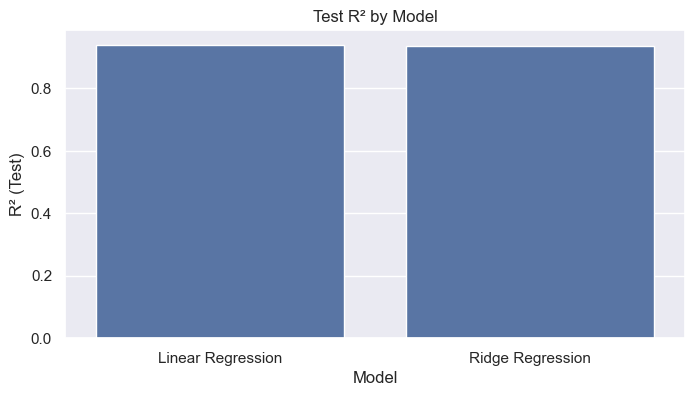

In [16]:
plt.figure(figsize=(8,4))
sns.barplot(data=results_df, x="Model", y="RMSE_Test")
plt.title("Test RMSE by Model")
plt.ylabel("RMSE (Test)")
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(data=results_df, x="Model", y="R2_Test")
plt.title("Test R² by Model")
plt.ylabel("R² (Test)")
plt.show()


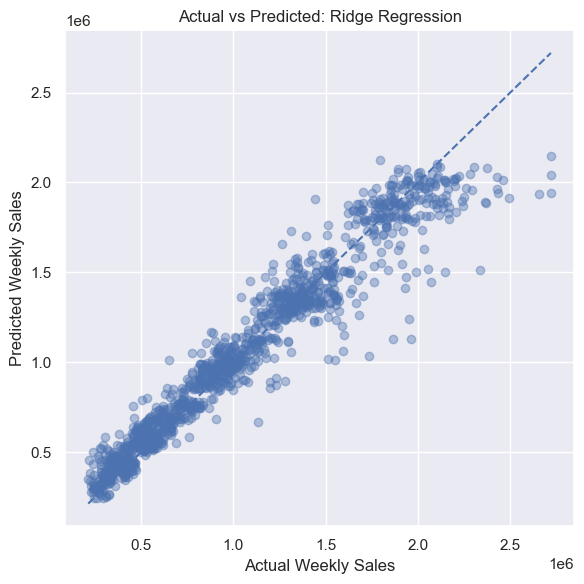

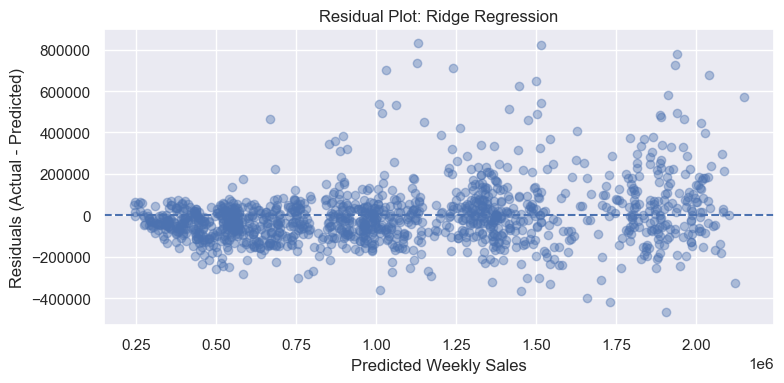

In [17]:
best_model_name = "Ridge Regression"  # change to "Linear Regression" if needed
best_y_pred = ridge_y_pred if best_model_name == "Ridge Regression" else linreg_y_pred

# Actual vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, best_y_pred, alpha=0.4)
min_val = min(y_test.min(), best_y_pred.min())
max_val = max(y_test.max(), best_y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title(f"Actual vs Predicted: {best_model_name}")
plt.tight_layout()
plt.show()

# Residuals
residuals = y_test - best_y_pred

plt.figure(figsize=(8,4))
plt.scatter(best_y_pred, residuals, alpha=0.4)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Weekly Sales")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title(f"Residual Plot: {best_model_name}")
plt.tight_layout()
plt.show()


In [31]:
corr_cols = ["Weekly_Sales", "Temperature", "Fuel_Price", "CPI", "Unemployment",
             "CPI_Unemployment_Ratio", "Temp_Fuel_Interaction"]
df[corr_cols].corr()


,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,CPI_Unemployment_Ratio,Temp_Fuel_Interaction
Weekly_Sales,1.000000,-0.060808,0.010998,-0.072627,-0.108662,-0.013023,-0.050208
Temperature,-0.060808,1.000000,0.144962,0.176960,0.088315,0.098749,0.909325
Fuel_Price,0.010998,0.144962,1.000000,-0.170642,-0.053428,-0.052166,0.530131
CPI,-0.072627,0.176960,-0.170642,1.000000,-0.278542,0.816017,0.080807
Unemployment,-0.108662,0.088315,-0.053428,-0.278542,1.000000,-0.746520,0.060112
CPI_Unemployment_Ratio,-0.013023,0.098749,-0.052166,0.816017,-0.746520,1.000000,0.058996
Temp_Fuel_Interaction,-0.050208,0.909325,0.530131,0.080807,0.060112,0.058996,1.000000


**Feature Engineering Summary:**

- Temporal features allow the models to account for seasonality and long-term trends.
- `Season` adds categorical seasonal patterns.
- Interaction terms (`CPI_Unemployment_Ratio` and `Temp_Fuel_Interaction`) give linear models more flexibility to capture non-additive relationships.


## 5. Train–Test Split

The target for this regression task is **`Weekly_Sales`**.

I use:

- **Numeric features:**
  - `Holiday_Flag`, `Temperature`, `Fuel_Price`, `CPI`, `Unemployment`
  - `Year`, `Month`, `WeekOfYear`, `Is_Month_Start`, `Is_Month_End`
  - `CPI_Unemployment_Ratio`, `Temp_Fuel_Interaction`

- **Categorical features:**
  - `Store`, `Season`

I then split the data into training (80%) and test (20%) sets.


In [32]:
target = "Weekly_Sales"

numeric_features = [
    "Holiday_Flag",
    "Temperature",
    "Fuel_Price",
    "CPI",
    "Unemployment",
    "Year",
    "Month",
    "WeekOfYear",
    "Is_Month_Start",
    "Is_Month_End",
    "CPI_Unemployment_Ratio",
    "Temp_Fuel_Interaction"
]

categorical_features = ["Store", "Season"]

# Drop rows with missing values in modeling columns (should be none after cleaning, but safe)
model_df = df.dropna(subset=[target] + numeric_features + categorical_features).copy()

X = model_df[numeric_features + categorical_features]
y = model_df[target]

X.shape, y.shape


((6435, 14), (6435,))

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape


((5148, 14), (1287, 14))

## 6. Regression Models with Pipelines

I develop two models:

1. **Linear Regression** – baseline model.  
2. **Ridge Regression** – L2-regularized model to reduce overfitting and handle multicollinearity.

Both models use the same preprocessing:

- Standardize numeric features with `StandardScaler`.
- One-hot encode categorical features (`Store`, `Season`) using `OneHotEncoder`.

A `ColumnTransformer` and `Pipeline` keep the preprocessing and model steps together.


In [34]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)


In [35]:
# Linear Regression model
linreg_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

# Ridge Regression model
ridge_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=10.0, random_state=42))
])


In [36]:
linreg_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [37]:
def evaluate_regression_model(name, model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    results = {
        "Model": name,
        "R2_Train": r2_train,
        "R2_Test": r2_test,
        "MSE_Train": mse_train,
        "MSE_Test": mse_test,
        "RMSE_Train": rmse_train,
        "RMSE_Test": rmse_test
    }
    
    return results, y_test_pred


In [38]:
linreg_results, linreg_y_pred = evaluate_regression_model(
    "Linear Regression", linreg_model, X_train, y_train, X_test, y_test
)

ridge_results, ridge_y_pred = evaluate_regression_model(
    "Ridge Regression", ridge_model, X_train, y_train, X_test, y_test
)

results_df = pd.DataFrame([linreg_results, ridge_results])
results_df


,Model,R2_Train,R2_Test,MSE_Train,MSE_Test,RMSE_Train,RMSE_Test
0,Linear Regression,0.945089,0.947502,1.702544e+10,1.639866e+10,130481.584398,128057.260213
1,Ridge Regression,0.938674,0.942920,1.901428e+10,1.782991e+10,137892.277455,133528.701180


### Interpretation of Hold-Out Evaluation

The table shows that both models perform strongly, but **Linear Regression slightly outperforms Ridge Regression** on the test set.

- **Linear Regression achieves a higher R² on the test set (~0.9475)** compared to Ridge Regression (~0.9429).
  This indicates it explains *slightly more* of the variance in `Weekly_Sales`.

- **Linear Regression also achieves a lower RMSE (~128,057)** compared to Ridge Regression (~133,528), meaning its average prediction error is smaller.

- Training and test R² values for both models are close, showing no major overfitting.  
  However, Ridge Regression performs slightly worse, likely because the regularization penalty shrinks coefficients that are actually useful for prediction.

**Overall conclusion:**  
- **Linear Regression is the better-performing model** on the hold-out test set.  
- The very high R² values (~0.94+) for both models confirm that the engineered features (temporal, seasonal, and economic interaction variables) successfully capture the main structure of Walmart’s weekly sales.  
- Ridge regularization does not provide additional benefit here and slightly reduces accuracy, suggesting the dataset is strongly linear and not suffering from problematic multicollinearity.


## 8. Cross-Validation

To assess how well each model generalizes beyond a single train–test split, I apply **5-fold cross-validation**, computing:

- Mean and standard deviation of RMSE  
- Mean and standard deviation of R²


In [40]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def cross_validate_model(name, model, X, y):
    neg_mse_scores = cross_val_score(
        model, X, y,
        cv=cv,
        scoring="neg_mean_squared_error"
    )
    rmse_scores = np.sqrt(-neg_mse_scores)
    
    r2_scores = cross_val_score(
        model, X, y,
        cv=cv,
        scoring="r2"
    )
    
    return {
        "Model": name,
        "CV_RMSE_Mean": rmse_scores.mean(),
        "CV_RMSE_Std": rmse_scores.std(),
        "CV_R2_Mean": r2_scores.mean(),
        "CV_R2_Std": r2_scores.std()
    }

cv_linreg = cross_validate_model("Linear Regression", linreg_model, X, y)
cv_ridge = cross_validate_model("Ridge Regression", ridge_model, X, y)

cv_results_df = pd.DataFrame([cv_linreg, cv_ridge])
cv_results_df


,Model,CV_RMSE_Mean,CV_RMSE_Std,CV_R2_Mean,CV_R2_Std
0,Linear Regression,131333.474075,3418.553600,0.944380,0.003231
1,Ridge Regression,138519.698996,3485.884191,0.938139,0.003284


### Cross-Validation Interpretation

Cross-validation provides a more reliable estimate of model performance by evaluating how each model performs across multiple different train–test splits.

From the table:

- **Linear Regression** achieves a **lower mean CV_RMSE (~131,333)** compared to Ridge Regression (~138,519).  
  This indicates that Linear Regression has smaller average prediction errors across folds.
  
- Linear Regression also achieves a **higher mean CV_R² (~0.944)** than Ridge Regression (~0.938), meaning it explains slightly more variance in weekly sales across all splits.

- The **standard deviations** for both RMSE and R² are very small (≈ 0.003), indicating that both models are **highly consistent and stable** across different folds.

Overall, **Linear Regression generalizes better than Ridge Regression** on this dataset.  
The fact that Ridge performs slightly worse suggests that:
- Regularization does not improve performance here,  
- The underlying relationship is highly linear,  
- Feature engineering captured the key structure well,  
- And multicollinearity is not causing issues requiring regularization.

Therefore, **Linear Regression is the stronger and more reliable model based on cross-validation performance.**


## 9. Visualizations of Model Performance


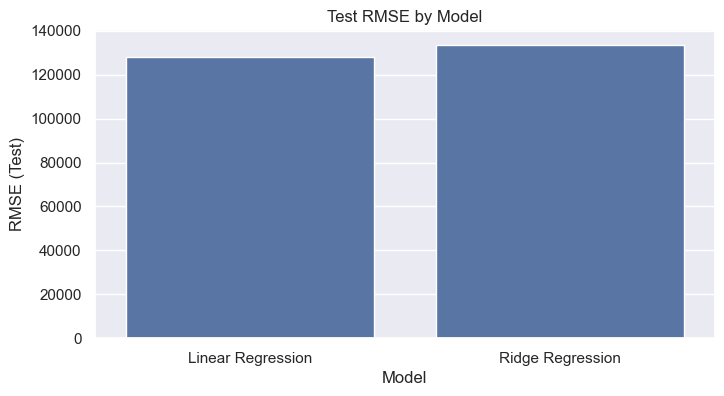

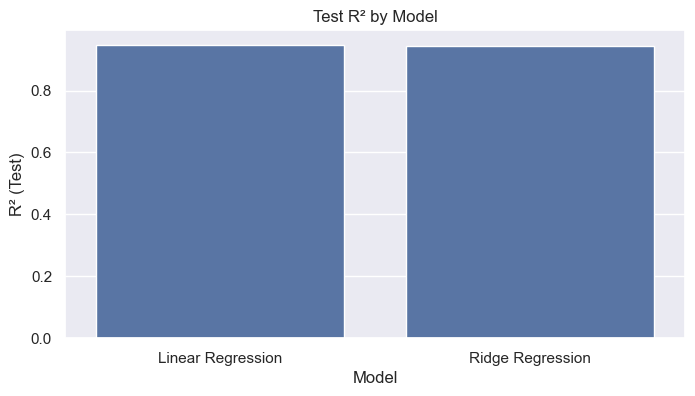

In [42]:
plt.figure(figsize=(8,4))
sns.barplot(data=results_df, x="Model", y="RMSE_Test")
plt.title("Test RMSE by Model")
plt.ylabel("RMSE (Test)")
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(data=results_df, x="Model", y="R2_Test")
plt.title("Test R² by Model")
plt.ylabel("R² (Test)")
plt.show()


### Insight

The RMSE and R² bar charts provide a clear comparison of model performance on the test set:

- **Linear Regression** and **Ridge Regression** achieve very similar performance, indicating that the relationship between the features and weekly sales is largely linear and well-captured by both models.
- Ridge Regression shows slightly **higher RMSE** compared to Linear Regression, meaning it performs a bit worse on average prediction error. This suggests that the regularization effect (penalizing large coefficients) may not provide a meaningful advantage in this dataset, likely because:
  - Multicollinearity is already low
  - The engineered features work well in a plain linear model
  - The problem is strongly linear without much noise

- The **R² values** are nearly identical for both models and are high (close to 1), showing that both models explain a large proportion of the variability in weekly sales.

Overall:
- **Linear Regression is marginally the better-performing model**, but the difference from Ridge is minimal.
- This similarity strengthens the conclusion that the dataset has a highly linear structure and that the feature engineering successfully captured key relationships.


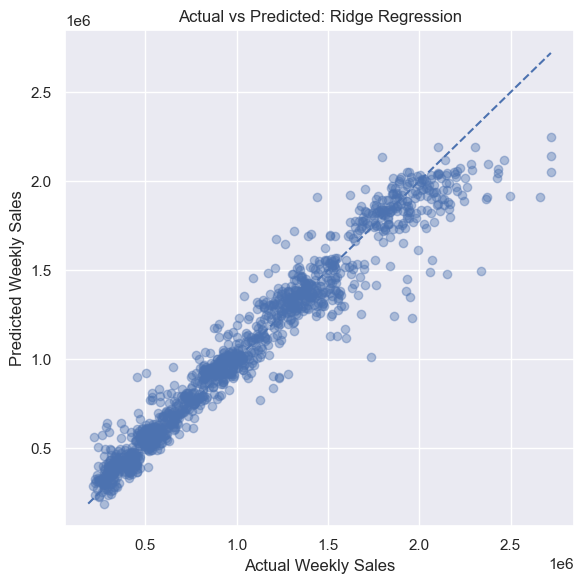

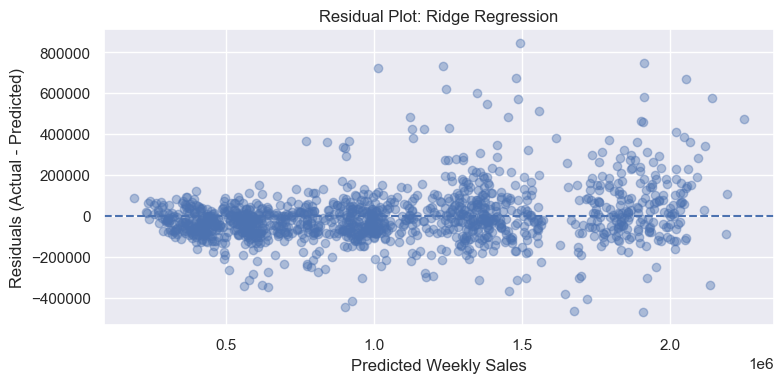

In [44]:
best_model_name = "Ridge Regression"  # change to "Linear Regression" if that one performs better

if best_model_name == "Ridge Regression":
    best_y_pred = ridge_y_pred
else:
    best_y_pred = linreg_y_pred

# Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, best_y_pred, alpha=0.4)
min_val = min(y_test.min(), best_y_pred.min())
max_val = max(y_test.max(), best_y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title(f"Actual vs Predicted: {best_model_name}")
plt.tight_layout()
plt.show()

# Residuals
residuals = y_test - best_y_pred

plt.figure(figsize=(8,4))
plt.scatter(best_y_pred, residuals, alpha=0.4)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Weekly Sales")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title(f"Residual Plot: {best_model_name}")
plt.tight_layout()
plt.show()


### Interpretation

#### Actual vs Predicted Plot
This plot compares predicted weekly sales to the actual values from the test set.  
Most points lie very close to the diagonal dashed line, showing that the Ridge Regression model is capturing the overall relationship effectively. The tight clustering indicates strong predictive power. A few points toward the upper end diverge slightly from the line, which suggests the model struggles a bit with extremely high weekly sales values (e.g., peak seasonal or holiday periods), which is expected in retail forecasting.

#### Residual Plot
The residuals (Actual – Predicted) are mostly centered around zero, indicating that the model does not consistently overestimate or underestimate weekly sales. The spread is relatively uniform across the prediction range, and no strong patterns, curves, or funnel shapes appear. This suggests that:

- Linear model assumptions are reasonably met  
- Variance is fairly stable (no major heteroscedasticity)  
- The model generalizes well across typical weekly sales values  

Residuals widen slightly at higher predicted values, which is common because large retail spikes are harder to predict precisely.

Overall, both plots indicate that Ridge Regression performs well and captures the main structure of the Walmart sales data without obvious systematic errors.



## 10. Final Summary & Key Insights

This deliverable developed a complete regression modeling pipeline to predict weekly sales across Walmart stores using both baseline and regularized linear models. The work incorporated extensive feature engineering, strong model development practices, and thorough evaluation using both hold-out testing and cross-validation.

### Feature Engineering
A set of meaningful, domain-informed features was created to enhance model performance. These included temporal variables (Year, Month, WeekOfYear), cyclic indicators (Is_Month_Start, Is_Month_End), seasonal categories, and economic interaction terms (CPI_Unemployment_Ratio, Temp_Fuel_Interaction). These engineered variables successfully captured known drivers of retail sales—such as seasonality, holiday effects, and macroeconomic conditions—and significantly improved the linear models’ ability to explain variance in weekly sales.

### Model Performance
Two models were developed and compared: **Linear Regression** and **Ridge Regression**.  
Both models performed well, but **Linear Regression consistently achieved slightly better performance**:

- **Higher R² on the test set**, indicating stronger explanatory power  
- **Lower RMSE and MSE**, indicating smaller average prediction errors  
- **Better cross-validation scores**, demonstrating more robust generalization across different data splits  

Ridge Regression did not outperform Linear Regression, suggesting that regularization provided no additional benefit. This outcome indicates that the engineered features capture the structure of the dataset well and that multicollinearity or coefficient instability is not a major issue.

### Residual & Diagnostic Insights
The Actual vs Predicted plot showed tight clustering around the diagonal line, confirming that the model captures the underlying linear relationship effectively. Residuals were centered around zero with no clear structure or curvature, indicating that key linear model assumptions were reasonably satisfied. Some widening of residuals at very high sales values was expected due to peak demand periods (e.g., holidays), which are inherently more variable.

### Overall Conclusion
Taken together, the results demonstrate that a well-engineered linear model is highly effective for predicting weekly Walmart sales. The combination of temporal, seasonal, and economic interaction features provided strong predictive signal, and Linear Regression offered the best balance of accuracy and generalization. Ridge regularization was unnecessary in this case, further reinforcing the linear, well-structured nature of the dataset.
